<a href="https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/rice_seed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rice Seed Classification

## Preface

How will you classify the bellow two images?

![rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/11.jpg) Proper Shaped Rice Seed

![rice](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/141.jpg) Broken Rice Seed


## Library and Custom Function Import

In [0]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [0]:
#confusion matrix drawing function provided by sklearn
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [3]:
!apt-get install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 8 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 [

## Dataset Import

In [0]:
!svn export https://github.com/totti0223/deep_learning_for_biologists_with_keras/trunk/notebooks/data/image image -q

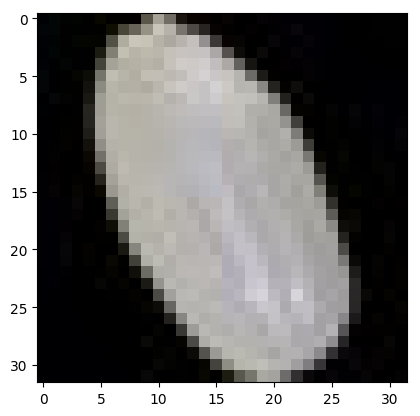

In [5]:
image = imread("image/train/proper/100.jpg")
plt.imshow(image)

In [6]:
#lets load everything into memory

X_train = []
y_train = []

for root, dirs, files in os.walk("image/train"):
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(32,32))
        X_train.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_train.append(0)
        else:
            y_train.append(1)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

for root, dirs, files in os.walk("image/test"):
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(32,32))
        X_test.append(image)        
        category = os.path.split(root)[-1]
        if category == "proper":
            y_test.append(0)
        else:
            y_test.append(1)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(377, 32, 32, 3) (377,)
(20, 32, 32, 3) (20,)


# 1. Defining threshold manually for classification

(32, 32, 3)


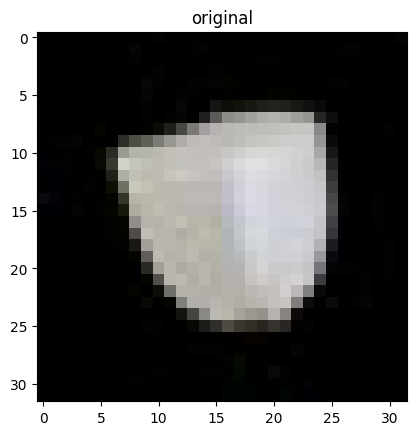

In [7]:
#Let's try it for one image
image = X_train[0]

#the original image
print(image.shape)
plt.imshow(image)
plt.title("original")
plt.show()

(32, 32)


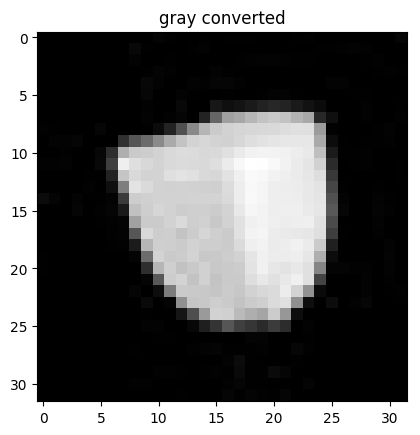

In [8]:
#gray conversion
gray = rgb2gray(image)
print(gray.shape)
plt.imshow(gray, cmap=plt.cm.gray)
plt.title("gray converted")
plt.show()

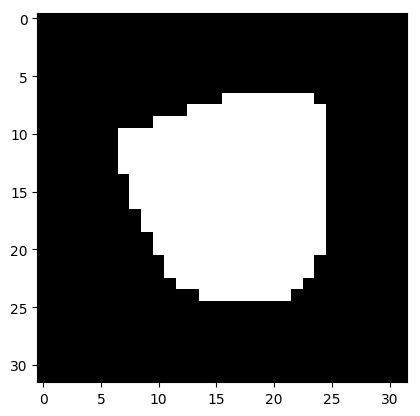

In [9]:
#binary conversion
threshold = threshold_otsu(gray)
binary = gray > threshold
plt.imshow(binary, cmap=plt.cm.gray)
plt.show()

Lets manually define the feature for classification. In this case, simply binarizing the image, extracting the area size of each image and then defining a threshold will do well. All of the image transformation and area measuring can be done with the functions of skimage and scipy.

In [10]:
label_im, nb_labels = ndimage.label(binary)
#検出された領域の特徴（幾何学的性質等）を取得しましょう。
#領域の明度も取得したいので参照用gray画像も併せて利用します。
regionprops = measure.regionprops(label_im, intensity_image=gray)
#複数領域の検出を前提として、regionproprsには結果が複数領域分格納されます。１つ目の領域を指定しましょう。
regionprop = regionprops[0]

#様々な情報を参照できます。
print(regionprop.area)
print(regionprop.major_axis_length)
print(regionprop.minor_axis_length)

265
18.960453228032428
18.350131979990607


In [11]:
#bundling the above into a function
def quantify_area(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    return area

#test
area = quantify_area(image)
print(area)

265


In [0]:
X_train_area = []
for image in X_train:
    area = quantify_area(image)
    X_train_area.append(area)

X_test_area = []
for image in X_test:
    area = quantify_area(image)
    X_test_area.append(area)

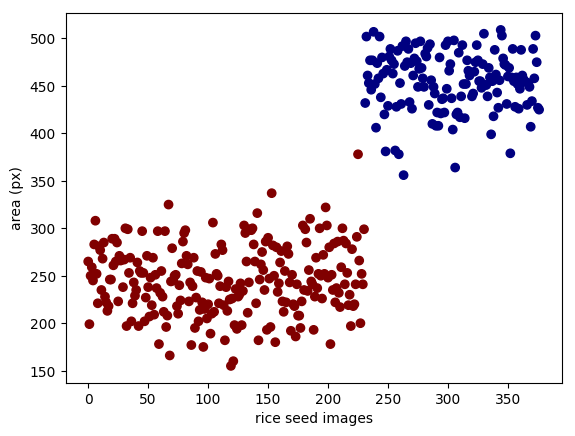

In [13]:
#check the calculated data area value of training dataset

plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap="jet")
plt.xlabel("rice seed images")
plt.ylabel("area (px)")
plt.show()

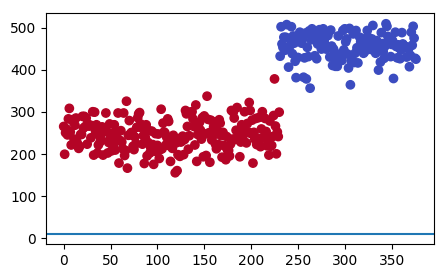

Confusion matrix, without normalization


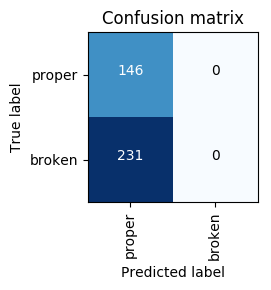

In [16]:
#define an area threshold that can seperate the two classes
area_threshold = 10

#classify whether the image is a proper seed or a broken seed according to the area_threshold value
train_y_pred = []
for area in X_train_area:
    if area > area_threshold:
        train_y_pred.append(0)
    else:
        train_y_pred.append(1)
        

#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
#plt.plot([100,0],[100,350],'k-',lw=2)
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_train, train_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])
plt.show()

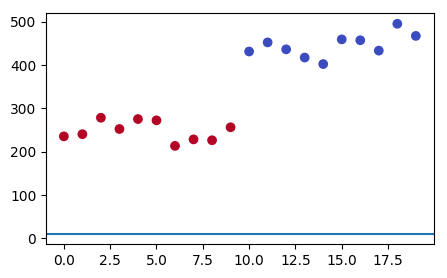

Confusion matrix, without normalization


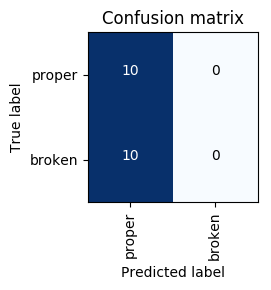

In [17]:
#evaluate it with the test dataset
test_y_pred = []
for area in X_test_area:
    if area > area_threshold:
        test_y_pred.append(0)
    else:
        test_y_pred.append(1)
        
#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_test_area)),X_test_area,c=y_test,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
#plt.plot([100,0],[100,350],'k-',lw=2)
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_test, test_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["proper","broken"])
plt.show()

correct label is:  1
predicted label is:  1


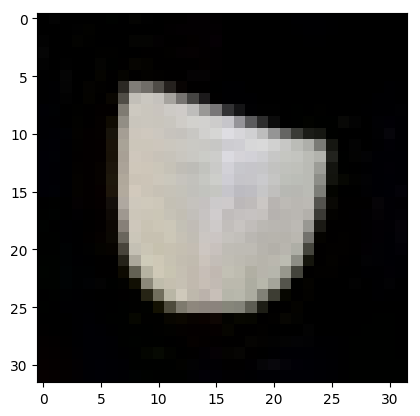

In [18]:
#build a classifier

def manual_classifier(image,area_threshold):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    if area > area_threshold:
        return 0
    else:
        return 1

# get a image from test dataset #value must be lower than the size of the test dataset(20-1)
n = 5
image = X_test[n]
label = y_test[n]
area_threshold = 350
prediction = manual_classifier(image,area_threshold)

plt.imshow(image)
print("correct label is: ",label)
print("predicted label is: ",prediction)

# Defining the most suitable threshold by support vector machine

In [19]:
#reshape list to numpy with suitable shape so that svm function can read it
X_train_area2 = np.array([[1,x] for x in np.array(X_train_area)])

#define linear support vector machine for defining the threshold
clf=svm.SVC(kernel="linear")
#train the classifier
clf.fit(X_train_area2,y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

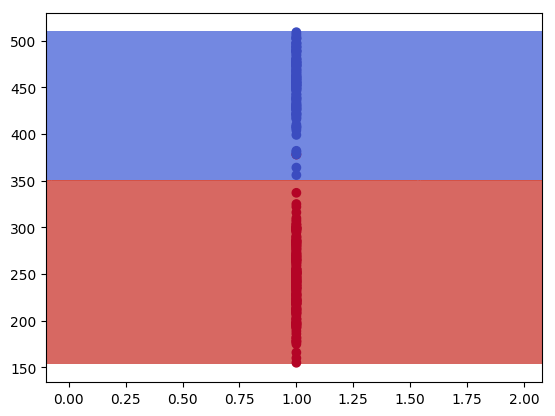

In [29]:
xx, yy = make_meshgrid(np.array([0.9,1.1]),X_train_area2[:,1])
plot_contours(clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train_area2[:,0],X_train_area2[:,1],c=y_train,cmap=plt.cm.coolwarm)


Note

The formula of support vector machine can be expressed by the following.
https://scikit-learn.org/stable/modules/svm.html
>$$\operatorname{sgn}(\sum_{i=1}^n y_i \alpha_i K(x_i, x) + \rho)$$
>This parameters can be accessed through the members dual_coef_ which holds the product , $$y_i \alpha_i$$ support_vectors_ which holds the support vectors, and intercept_ which holds the independent term  : $$\rho$$



In [33]:
#閾値を手で設定するのは少々大変です。
#レベル２人工知能をつかって閾値を自動的に計算してもらいましょう。
#今回はサポートベクターマシーン（機械学習の一種）による計算を行います。

#念の為読み込みなおす。
#---------------------------
df =pd.read_csv("output.csv")

x = df[["Area","Major_axis_length"]] #xに二列分のデータを読み込みます。
X = x.as_matrix() #配列に変換しています。
y = df["Grain_type"] #区分を読み込みます。
y = y.as_matrix()
#---------------------------

C = 1.0  # SVM regularization parameter
svc=svm.SVC(kernel='linear',C=C).fit(X,y)

h = .02  # step size in the mesh
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Area')
plt.ylabel('Major_axis_length')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()


#結果はどのように表示されましたか？
#レベル１では面積のみを指標にしましたが、サポートベクターマシーンは面積と長軸長双方とも使用しているようですね。

FileNotFoundError: ignored

In [0]:
#作成した分類器はこのように使うことができます。
virtual_rice = [400,35]  #面積、長軸長
value = np.array(virtual_rice).reshape(1,-1)
prediction = svc.predict(value)
print ("入力された情報から推測される分類クラスは",prediction,"です")
#１が整粒米、２が割れ米です。
#virtual_riceの情報を色々変えてみて結果がどうかわるか試してみて下さい。

入力された情報から推測される分類クラスは [1] です


In [0]:
#おまけ。分類器の保存と復元
#保存したファイルを取っておいて、他のプログラムと組み合わせる事ができます。
#http://web-salad.hateblo.jp/entry/2014/11/09/090000
joblib.dump(svc,'svm_checkpoint.pkl') #保存します
svc=joblib.load('svm_checkpoint.pkl') #復元します
print (svc.predict(value)) #使います。

[1]


In [0]:
#ちなみに他のパラメーターを使用するとどうなるでしょうか？
#整流米は割れ米に比べて楕円らしさが高いですね。
#regionspropsに楕円らしさを測るeccentricityがあります(1が完全な楕円)。それを使用してみましょう。
#csvに保存せずに変数の受け渡しのみで最後までいってみましょう。

proper_ec = [] #空のリストを作成します
broken_ec = []

proper_seeds = get_file_list_in_folder("image/train/proper")  #前に定義した関数を使いまわします。
broken_seeds = get_file_list_in_folder("image/train/broken")

for path_of_image in proper_seeds:
    image = imread(path_of_image)
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    if len(regionprops) == 1: #1個のみ領域が検出された場合、以下の処理を行う。
        a = regionprops[0].eccentricity
        proper_ec.append(a) #楕円度

for path_of_image in broken_seeds:
    image = imread(path_of_image)
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    if len(regionprops) == 1: #1個のみ領域が検出された場合、以下の処理を行う。
        a = regionprops[0].eccentricity
        broken_ec.append(a) #楕円度


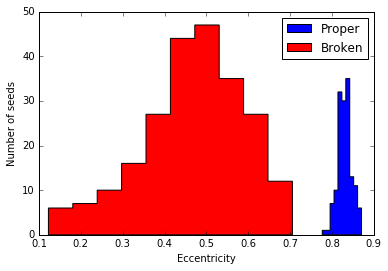

In [0]:
plt.hist(proper_ec,bins=10,histtype='stepfilled', color='b', label='Proper')
plt.hist(broken_ec,bins=10,histtype='stepfilled', color='r', label='Broken')
plt.legend()
plt.xlabel("Eccentricity")
plt.ylabel("Number of seeds")
plt.show()

#このような尺度（特徴量）でも分類することができそうですね。
#このように特徴量設計（定義）がうまくいけば高精度で解析が可能です。ただ、生物情報の解析は往々にして
#うまくいきません、そのような時はレベル３人工知能で紹介するディープラーニングが強い力を発揮します。
#ディープラーニングを利用すると、特徴量設計をコンピュータにまかせることができます。

In [0]:
#次はディープラーニング、レベル３人工知能

In [0]:
from __future__ import print_function
import keras
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [0]:
#ディレクトリから画像を読み込みます。

train_datagen = ImageDataGenerator( #data augmentation　訓練データを水増しします。
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
        'image/train/',
        target_size=(32, 32), #height,widthのサイズに強制リサイズします。
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'image/valid/',
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')

print (train_generator.class_indices)
print (validation_generator.class_indices)
#one hot encoding.　正常　＝ [0,1]　割れ= [1,0]といったラベルになっています

Found 377 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
{'proper': 1, 'broken': 0}
{'proper': 1, 'broken': 0}


In [0]:
#モデルの定義。cifar-10のサンプルを流用しています。


input_shape = (32,32,3)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
#モデルをチェックしてみましょう。
model.summary()

In [0]:
model.fit_generator(
        train_generator,
        samples_per_epoch=1000,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=10)

model.save("model.hdf5")

In [0]:
#model.load_weights("model.hdf5")で読み込むことができます。このnotebookを閉じない限りmodelは読み込まれたままです。
from skimage.transform import resize

inputdata = imread("image/146.jpg")/255.
inputdata = resize(inputdata,(32,32))
inputdata = np.expand_dims(inputdata,axis=0)
print(inputdata.shape)

#(1, 32, 32, 3)　（バッチ、height, width, channel）
#モデルには複数の画像（バッチ）を入力するようにしているので、単一のバッチと定義するため、expand_dimを使用
#カラーなので、最後の3はRGBで3チャネルです。

y = model.predict(inputdata)
#0~1の結果が返ってくるので１００をかけて０〜１００％表示に修正
print(y*100.0)

#[0,1]で100%正常米
#[1,0]で100%割れ米


result = np.argmax(y) #何番目の数値が大きいか
if result == 0:
    print ("この画像は割れ米の可能性",y[0][0]*100,"%です")

if result == 1:
    print ("この画像は正常米の可能性",y[0][1]*100,"%です")



(1, 32, 32, 3)
[[  9.99642715e+01   3.57273631e-02]]
この画像は割れ米の可能性 99.9642729759 %です


In [0]:
#第１層のフィルタの可視化や
#フィルタ適用後の画像等を表示すると、ネットワークがどのように学習しているかより深い理解が可能になります。
#インターネットの様々なサイトでコードを参照できるので各自調べてみて下さい。

#今日はここまでです。